# CRF Baseline Model for Environmental NER

## 1. Introduction

### 1.1 Background and Purpose
This notebook begins the model training phase of the environmental Named Entity Recognition (NER) pipeline. The annotated dataset, created using rule-based string matching against curated environmental vocabularies, is now used to train machine learning models that can recognise entity spans more generally.

Conditional Random Fields (CRFs) are used in this stage as a classical baseline. CRFs have a long-standing reputation in NER tasks for their ability to model label sequences while accounting for contextual dependencies. They serve as a transparent starting point to assess the quality of features and labels before moving on to more complex neural models. This also allows us to interpret which features are most informative and where the model succeeds or fails in recognising environmental entities.

The annotated dataset contains 735,542 sentences and over 1.2 million entity spans. It is based on five entity types: TAXONOMY, HABITAT, ENV_PROCESS, POLLUTANT, and MEASUREMENT. Each entity was matched from curated domain vocabularies and labelled using the BIO tagging scheme.

This stage will also help identify any structural gaps in the data or annotation errors that may affect downstream performance.

### 1.2 Objectives
This notebook aims to train and evaluate a Conditional Random Fields (CRF) model as a baseline for the environmental NER task. It builds on the annotated dataset produced in earlier stages and explores whether a feature-based sequence model can learn to generalise from rule-based labels.

Key objectives include:
- Prepare the dataset in BIO format for CRF training.
- Extract interpretable features from tokens and their context.
- Train multiple CRF models using different hyperparameter settings.
- Evaluate performance on both validation and test sets.
- Identify strengths and limitations of the CRF model as a baseline.

## 2. Preparing the Dataset
Before training, the dataset needs to be structured in a suitable format. After the annotation stage, the data was stored in .jsonl format, compatible with SpaCy. However, the CRF model expects the data in BIO format.

BIO (Begin–Inside–Outside) is a standard tagging scheme used for sequence labelling. Each token is assigned a tag based on its role within an entity:

- B- marks the beginning of an entity
- I- marks continuation inside the same entity
- O is used for tokens that do not belong to any entity

For example, the phrase: `acid rain is harmful` might be tagged as:

```
acid    B-ENV_PROCESS
rain    I-ENV_PROCESS
is      O
harmful O
```

In the next step, the `jsonl` data is converted into BIO-tagged CoNLL format for CRF training.

In [28]:
import os
import spacy
import json
from pathlib import Path
import pprint
import random
from collections import Counter

import joblib
from joblib import load

from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

JSON_DATA_PATH = Path("../data/json/training_data.jsonl")
CRF_MODEL_PATH = Path("../models/crf")
os.makedirs(CRF_MODEL_PATH, exist_ok=True)

In [3]:
def jsonl_to_conll(jsonl_path):
    nlp = spacy.blank("en")
    conll_data = []
    with open(jsonl_path, "r", encoding="utf8") as f:
        for line in f:
            data = json.loads(line)
            text = data["text"]
            entities = data.get("label", [])

            # convert character spans to token labels
            doc = nlp(text)
            tags = ["O"] * len(doc)

            for start_char, end_char, label in entities:
                for token in doc:
                    if token.idx >= start_char and token.idx < end_char:
                        tag = f"I-{label}"
                        if token.idx == start_char:
                            tag = f"B-{label}"
                        tags[token.i] = tag

            sentence = [(token.text, tags[token.i]) for token in doc]
            conll_data.append(sentence)

    return conll_data

In [4]:
conll_data = jsonl_to_conll(JSON_DATA_PATH)

In [ ]:
def print_random_conll_sentences(conll_data, n=5):
    sample = random.sample(conll_data, n)
    for sentence in sample:
        for token, tag in sentence:
            print(f"{token}\t{tag}")
        print()

In [5]:
print_random_conll_sentences(conll_data, n=5)

This	O
paper	O
reviewed	O
the	O
impacts	O
of	O
climate	B-ENV_PROCESS
change	I-ENV_PROCESS
on	O
the	O
management	O
of	O
the	O
water	O
sector	O
in	O
Malaysia	O
discussing	O
the	O
current	O
status	O
of	O
water	O
resources	O
,	O
water	O
service	O
,	O
and	O
water	O
-	O
related	O
disasters	O
.	O

The	O
major	O
invaders	O
found	O
in	O
these	O
clusters	O
of	O
islands	B-HABITAT
are	O
feral	O
cats	B-TAXONOMY
,	O
feral	O
dogs	B-TAXONOMY
,	O
pigs	B-TAXONOMY
and	O
rats	B-TAXONOMY
.	O

Chernicharo	O
CA(1	O
)	O
,	O
Almeida	O
PG	B-MEASUREMENT
,	O
Lobato	O
LC	O
,	O
Couto	O
TC	O
,	O
Borges	O
JM	O
,	O
Lacerda	O
YS	O
.	O

In	O
2016	O
,	O
the	O
then	O
water	O
minister	O
,	O
Barnaby	O
Joyce	O
,	O
announced	O
a	O
plan	O
to	O
introduce	O
the	O
herpes	O
virus	O
into	O
the	O
carp	B-TAXONOMY
population	O
to	O
control	O
their	O
numbers	O
.	O

Mantis	O
shrimp	O
are	O
typically	O
divided	O
into	O
two	O
categories	O
:	O
“	O
spearers	O
”	O
brandish	O
claws	O
lined	O
with	O
barbed	O
tips	O
to	O
stab	O
soft	O
-	O
bodie

The output confirms that the BIO conversion has worked as expected. Multi-token entities such as `climate change` have been correctly labelled as `B-ENV_PROCESS` and `I-ENV_PROCESS`, and single-token entity mentions like `cats`, `feral dogs`, and `carp"` have been assigned appropriate `B-TAXONOMY` tags.

Entities are clearly distinguished from non-entity tokens, which are correctly labelled with `O`. The tagging also shows the model's potential to learn boundaries across a variety of sentence structures and domains, including scientific abstracts, policy documents, and ecological descriptions.

This confirms the dataset is now in a suitable BIO-tagged format for feature extraction and model training.

## 3. Training a CRF Model

### 3.1 Feature Extraction for CRF
Classical models like CRF cannot operate directly on raw text. Instead, they require each token to be converted into a structured set of features. These features help the model learn useful patterns about entity boundaries based on the token and its surrounding context.

The `word2features` function below creates a dictionary of attributes for each token. It includes information such as the token's casing, whether it is a digit, and its suffixes. It also incorporates features from the previous and next tokens, giving the model context during training.

This type of hand-crafted feature design is critical for CRF models, as it forms the only input representation for each word, in contrast to deep learning models that use embeddings.

In [5]:
def word2features(sentence, i):
    word = sentence[i][0]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }

    if i > 0:
        prev_word = sentence[i - 1][0]
        features.update({
            '-1:word.lower()': prev_word.lower(),
            '-1:word.istitle()': prev_word.istitle(),
            '-1:word.isupper()': prev_word.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sentence) - 1:
        next_word = sentence[i + 1][0]
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(),
        })
    else:
        features['EOS'] = True

    return features

def sentence_to_features(sentence):
    return [word2features(sentence, i) for i in range(len(sentence))]

def sentence_to_labels(sentence):
    return [label for _, label in sentence]

def sentence_to_tokens(sentence):
    return [token for token, _ in sentence]


Below, we inspect the features and labels for two tokens from the first training sentence: one that is not part of any entity (`O`) and one that is a named entity (`B-POLLUTANT`). This comparison helps illustrate how the CRF model receives and processes feature representations for different types of tokens.

In [16]:
for i, (token, label) in enumerate(conll_data[12]):
    print(f"{i:2d}: {token:<15} {label}")

 0: This            O
 1: method          O
 2: was             O
 3: used            O
 4: as              O
 5: it              O
 6: bleaches        B-POLLUTANT
 7: and             O
 8: loosens         O
 9: organic         O
10: material        O
11: and             O
12: sediment        O
13: ,               O
14: leaving         O
15: the             O
16: charcoal        O
17: clean           O
18: .               O


In [18]:
o_features = sentence_to_features(conll_data[12])[2]
o_label = sentence_to_labels(conll_data[12])[2]

pollutant_features = sentence_to_features(conll_data[12])[6]
pollutant_label = sentence_to_labels(conll_data[12])[6]

print("Features for regular token (O):")
pprint.pprint(o_features)
print("Label:", o_label)

print("\nFeatures for annotated token (B-POLLUTANT):")
pprint.pprint(pollutant_features)
print("Label:", pollutant_label)

Features for regular token (O):
{'+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': 'used',
 '-1:word.istitle()': False,
 '-1:word.isupper()': False,
 '-1:word.lower()': 'method',
 'bias': 1.0,
 'word.isdigit()': False,
 'word.istitle()': False,
 'word.isupper()': False,
 'word.lower()': 'was',
 'word[-2:]': 'as',
 'word[-3:]': 'was'}
Label: O

Features for annotated token (B-POLLUTANT):
{'+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': 'and',
 '-1:word.istitle()': False,
 '-1:word.isupper()': False,
 '-1:word.lower()': 'it',
 'bias': 1.0,
 'word.isdigit()': False,
 'word.istitle()': False,
 'word.isupper()': False,
 'word.lower()': 'bleaches',
 'word[-2:]': 'es',
 'word[-3:]': 'hes'}
Label: B-POLLUTANT


The two examples illustrate how CRF models learn from features associated with each token, including the surrounding context. The first example represents a non-entity token (`was`), while the second is a named entity (`bleaches`) labelled as `B-POLLUTANT`.

**Contextual features**  
For both tokens, the feature function captures the lowercase forms and casing of the previous and next words (e.g. `'-1:word.lower()': 'method'`, `'+1:word.lower()': 'used'` for *was*, and `'-1:word.lower()': 'it'`, `'+1:word.lower()': 'and'` for *bleaches*). These help the CRF model understand how each token fits into its local sentence context.

**Surface features**  
The features include checks for whether the word is a digit, uppercase, or title case. These are useful signals for identifying abbreviations, codes, or names — but in this case, both tokens are lowercase common words.

**Suffix features**  
Each token includes the final two and three characters (`word[-2:]`, `word[-3:]`). For *bleaches*, the suffix `-es` and `-hes` may indicate a verb in third-person singular form, but in environmental contexts, such forms often align with chemical names or pollutant actions.

**Bias term**  
Both tokens include a constant `'bias': 1.0`, which serves as a baseline signal for the CRF model to adjust its weightings during training.

While the token `was` is a functional word with no relevance to entities, *bleaches* is a content word strongly associated with chemical substances. Despite sharing structural similarities, the CRF can learn from the lexical identity and surrounding context that *bleaches* is more likely to be part of a named entity span, whereas `was` is not.

### 3.2 Train–Validation–Test Split

Before training the CRF model, the annotated data must be divided into separate subsets for training, validation, and testing. This ensures that model performance can be evaluated on unseen data and prevents overfitting.

In this notebook, the preprocessed dataset is randomly partitioned into:
- **80% training data**: used to fit the model.
- **10% validation data**: used to tune hyperparameters and monitor generalisation during model development.
- **10% test data**: held back for final evaluation.

The split is stratified at the sentence level, maintaining a representative distribution of entity types across all subsets. Random state is fixed for reproducibility.

While this 80–10–10 split is standard and suitable for large datasets, other strategies such as k-fold cross-validation may be considered if the dataset were smaller or more imbalanced. In this case, the size and entity balance of the corpus are sufficient for this fixed-split approach.

In [6]:
# 80% train, 10% val, 10% test
train_data, temp_data = train_test_split(conll_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Feature and label extraction
X_train = [sentence_to_features(sent) for sent in train_data]
y_train = [sentence_to_labels(sent) for sent in train_data]

X_val = [sentence_to_features(sent) for sent in val_data]
y_val = [sentence_to_labels(sent) for sent in val_data]

X_test = [sentence_to_features(sent) for sent in test_data]
y_test = [sentence_to_labels(sent) for sent in test_data]

In [7]:
print(f"Train set: {len(train_data):,} sentences, {sum(len(s) for s in train_data):,} tokens")
print(f"Validation set: {len(val_data):,} sentences, {sum(len(s) for s in val_data):,} tokens")
print(f"Test set: {len(test_data):,} sentences, {sum(len(s) for s in test_data):,} tokens")

Train set: 588,433 sentences, 18,657,912 tokens
Validation set: 73,554 sentences, 2,337,011 tokens
Test set: 73,555 sentences, 2,331,547 tokens


The dataset has been successfully partitioned into training, validation, and test sets with a consistent 80–10–10 ratio. Each subset contains a large number of sentences and tokens, ensuring that the model has enough data to learn, validate, and generalise effectively. The sizes are balanced and representative, with over 18 million tokens in the training set and over 2.3 million each in the validation and test sets. This confirms the dataset is well-prepared for training and evaluation in the CRF pipeline.

### 3.3 Training the baseline CRF model
This section trains a Conditional Random Field (CRF) model using the `sklearn-crfsuite` package to serve as a classical baseline. `Sklearn-crfsuite` offers full control over feature design, regularisation parameters, and optimisation settings through a direct interface.

The function `train_crf_model` encapsulates the training routine. It accepts training and validation data, configures the CRF model using the L-BFGS algorithm, fits it to the training data, and evaluates its performance on the validation set. The trained model is also saved to disk for later reuse.

This setup allows systematic exploration of hyperparameters such as `c1` and `c2` (L1 and L2 regularisation strengths), as well as `max_iter`, which controls the number of optimisation steps. Validation performance is printed after training to provide early feedback before applying the model to the test set.


In [9]:
def train_crf_model(name, X_train, y_train, X_val, y_val, c1=0.1, c2=0.1, max_iter=100):
    print(f"Training model {name} with c1={c1}, c2={c2}, max_iter={max_iter}")
    
    crf = CRF(
        algorithm='lbfgs',
        c1=c1,
        c2=c2,
        max_iterations=max_iter,
        all_possible_transitions=True,
        verbose=True
    )
    
    crf.fit(X_train, y_train)

    model_path = os.path.join(CRF_MODEL_PATH, f"{name}.joblib")
    joblib.dump(crf, model_path)
    print(f"Saved model to: {model_path}")

    # Evaluate on validation set
    y_pred = crf.predict(X_val)
    print(f"Evaluation Report for {name}:")
    print(flat_classification_report(y_val, y_pred))

    return crf

The first CRF model uses no L1 or L2 regularisation `c1=0.0`, `c2=0.0` and runs for 30 iterations. This lets the optimiser fit the data freely without any penalty on weight size or feature count. It gives a starting point for understanding how regularisation influences feature sparsity and generalisation.

This setup helps assess how the model performs when it retains all extracted features and makes no attempt to reduce complexity.

In [10]:
crf_1 = train_crf_model("crf_model1", X_train, y_train, X_val, y_val, c1=0.0, c2=0.0, max_iter=30)

Training model crf_model1 with c1=0.0, c2=0.0, max_iter=30


loading training data to CRFsuite: 100%|█| 588433/588433 [02:19<00:00, 421



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 1022633
Seconds required: 23.890

L-BFGS optimization
c1: 0.000000
c2: 0.000000
num_memories: 6
max_iterations: 30
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=26.07 loss=22387701.09 active=1022633 feature_norm=1.00
Iter 2   time=13.12 loss=20527000.49 active=1022633 feature_norm=8.61
Iter 3   time=78.97 loss=6385566.15 active=1022633 feature_norm=3.57
Iter 4   time=26.55 loss=6075486.29 active=1022633 feature_norm=3.46
Iter 5   time=13.18 loss=5888321.32 active=1022633 feature_norm=3.49
Iter 6   time=13.62 loss=5736419.57 active=1022633 feature_norm=3.69
Iter 7   time=13.53 loss=5277729.47 active=1022633 feature_norm=4.83
Iter 8   time=13.11 loss=4813457.01 active=1022633 feature_norm=7.22
Iter 9   time=13.14 loss=4498110.85 active=

#### Model Statistics
| Model    | c1 (L1) | c2 (L2) | Iterations | Active Features | Macro F1 |
|----------|---------|---------|------------|------------------|----------|
| Model 1  | 0.0     | 0.0     | 30         | 1,022,633        | 0.61     |

The model retains all `1,022,633` features and completes 30 full iterations. Loss decreases steadily, and feature weights increase without limits, since there is no regularisation.

Evaluation shows strong results for frequent entity types like `B-ENV_PROCESS` and `B-HABITAT`, and excellent precision for the O class, which dominates the dataset. However, performance drops sharply for less common or inner tags. The F1-score for `B-TAXONOMY` is 0.40, and for `I-TAXONOMY` it is only 0.14.

These results show that the model captures basic structure and learns well on common classes, but struggles with rare or more complex entities. The lack of regularisation and high feature count make the model prone to overfitting, especially given the weakly labelled training data. Future models will apply regularisation to help improve generalisation and reduce noise.

### 3.4 CRF Model 2: Adding L2 Regularisation
The first model was trained with no regularisation and only 30 optimisation steps. It performed well on common entities but struggled with rare or more difficult ones. It also kept all 1 million+ features, which can make the model too complex and less general.

This second model adds L2 regularisation `c2=0.5` to reduce the effect of less useful features by shrinking their weights. The number of training steps is also increased to 50 to give the model more time to learn.

This setup tests whether regularisation helps the model perform better on less frequent entity types, while still keeping good results overall.

In [11]:
crf_2 = train_crf_model("crf_model2", X_train, y_train, X_val, y_val, c1=0.0, c2=0.5, max_iter=50)

Training model crf_model2 with c1=0.0, c2=0.5, max_iter=50


loading training data to CRFsuite: 100%|█| 588433/588433 [02:23<00:00, 408



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 1022633
Seconds required: 24.307

L-BFGS optimization
c1: 0.000000
c2: 0.500000
num_memories: 6
max_iterations: 50
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=26.50 loss=22387701.59 active=1022633 feature_norm=1.00
Iter 2   time=13.35 loss=20527029.64 active=1022633 feature_norm=8.61
Iter 3   time=80.24 loss=6385546.42 active=1022633 feature_norm=3.57
Iter 4   time=26.69 loss=6075494.56 active=1022633 feature_norm=3.46
Iter 5   time=13.30 loss=5888326.63 active=1022633 feature_norm=3.49
Iter 6   time=13.27 loss=5736429.22 active=1022633 feature_norm=3.69
Iter 7   time=13.33 loss=5277694.76 active=1022633 feature_norm=4.83
Iter 8   time=13.34 loss=4813457.73 active=1022633 feature_norm=7.22
Iter 9   time=13.19 loss=4498066.63 active=

#### Model Statistics
| Model    | c1 (L1) | c2 (L2) | Iterations | Active Features | Macro F1 |
|----------|---------|---------|------------|------------------|----------|
| Model 1  | 0.0     | 0.0     | 30         | 1,022,633        | 0.61     |
| Model 2  | 0.0     | 0.5     | 50         | 1,022,633        | 0.74     |

The results show that adding L2 regularisation and allowing more optimisation steps led to a noticeable improvement over the previous model. The macro-average F1 score increased from 0.61 to 0.74, with better recall and precision across nearly all entity types, particularly `B-POLLUTANT`, `B-MEASUREMENT`, and `B-HABITAT`.

Entity types with fewer examples, such as `I-TAXONOMY`, still showed lower scores, but some gains were made. The number of active features remained the same as no feature pruning was applied, but the L2 penalty helped the model generalise more effectively.

The optimiser completed all 50 iterations and continued to reduce the loss steadily, suggesting the model was still learning and had not yet plateaued. This supports the idea that more iterations or further tuning may yield even better performance in future models.

### 3.5 CRF Model 3: Balanced L1 and L2 Regularisation with Increased Iterations
CRF Model 3 uses both L1 `c1=0.1` and L2 `c2=0.1` regularisation, introducing sparsity while still controlling large weights. The model is trained for 70 iterations to allow more time for the optimiser to converge compared to the previous models.

This setup tests whether combining L1 and L2 regularisation helps the model perform better on rare or complex entity types, while also reducing the number of active features to improve generalisation and interpretability.

In [12]:
crf_3 = train_crf_model("crf_model3", X_train, y_train, X_val, y_val, c1=0.1, c2=0.1, max_iter=70)

Training model crf_model3 with c1=0.1, c2=0.1, max_iter=70


loading training data to CRFsuite: 100%|█| 588433/588433 [02:20<00:00, 417



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 1022633
Seconds required: 23.868

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 70
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=26.07 loss=22387701.97 active=1020113 feature_norm=1.00
Iter 2   time=13.07 loss=20227599.41 active=1018481 feature_norm=8.59
Iter 3   time=13.09 loss=18073579.15 active=995678 feature_norm=7.77
Iter 4   time=175.00 loss=9114868.57 active=521723 feature_norm=3.64
Iter 5   time=39.59 loss=6526444.32 active=1010126 feature_norm=8.71
Iter 6   time=13.23 loss=6097114.59 active=809732 feature_norm=10.04
Iter 7   time=52.88 loss=5713363.20 active=976074 feature_norm=9.72
Iter 8   time=52.65 loss=5593629.51 active=829655 feature_norm=7.40
Iter 9   time=39.26 loss=5315319.41 active=81

#### Model Statistics
| Model    | c1 (L1) | c2 (L2) | Iterations | Active Features | Macro F1 |
|----------|---------|---------|------------|------------------|----------|
| Model 1  | 0.0     | 0.0     | 30         | 1,022,633        | 0.61     |
| Model 2  | 0.0     | 0.5     | 50         | 1,022,633        | 0.74     |
| Model 3  | 0.1     | 0.1     | 70         | 119,639          | 0.96     |

CRF Model 3 shows a clear improvement over the earlier models. The macro F1-score rises to 0.96, up from 0.74 in Model 2. The model also performs better on rare or difficult entity types, including `B-TAXONOMY`, `I-TAXONOMY`, and `I-POLLUTANT`.

The L1 regularisation removes a large number of features, reducing the active feature count to 119,639. This makes the model simpler and more focused on useful patterns. The training loss dropped steadily and feature norms grew gradually, suggesting the optimiser found a stable solution without overfitting.

These results highlight the advantage of combining both L1 and L2 regularisation to balance sparsity and generalisation.

### 3.6 CRF Model 4: Higher Iterations with Stronger L2 and Light L1 Regularisation
Building on the success of the previous model, this configuration explores whether stronger L2 regularisation and longer training can further improve generalisation. CRF Model 4 uses a higher L2 penalty `c2=0.5` while applying a lighter L1 penalty `c1=0.01`. The number of optimisation steps is also increased to 120.

This setup allows the model to retain a broader set of useful features (due to the low L1) while still applying strong smoothing via L2. The increased iterations provide additional training time, which is expected to benefit convergence and improve handling of rare or complex entity patterns without overfitting.

In [13]:
crf_4 = train_crf_model("crf_model4", X_train, y_train, X_val, y_val, c1=0.01, c2=0.5, max_iter=120)

Training model crf_model4 with c1=0.01, c2=0.5, max_iter=120


loading training data to CRFsuite: 100%|█| 588433/588433 [02:16<00:00, 432



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 1022633
Seconds required: 21.374

L-BFGS optimization
c1: 0.010000
c2: 0.500000
num_memories: 6
max_iterations: 120
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=24.94 loss=22387701.67 active=1021826 feature_norm=1.00
Iter 2   time=12.54 loss=20227617.34 active=1018960 feature_norm=8.59
Iter 3   time=12.55 loss=18073587.71 active=996121 feature_norm=7.77
Iter 4   time=167.07 loss=8732812.62 active=980395 feature_norm=3.65
Iter 5   time=37.59 loss=6492273.21 active=1012453 feature_norm=8.58
Iter 6   time=12.54 loss=6136378.52 active=933780 feature_norm=9.90
Iter 7   time=50.45 loss=5652501.69 active=1018008 feature_norm=8.06
Iter 8   time=63.04 loss=5318081.45 active=1018042 feature_norm=7.64
Iter 9   time=37.73 loss=5264848.77 active=

#### Model Statistics

| Model    | c1 (L1) | c2 (L2) | Iterations | Active Features | Macro F1 |
|----------|---------|---------|------------|------------------|----------|
| Model 1  | 0.0     | 0.0     | 30         | 1,022,633        | 0.61     |
| Model 2  | 0.0     | 0.5     | 50         | 1,022,633        | 0.74     |
| Model 3  | 0.1     | 0.1     | 70         | 119,639          | 0.96     |
| Model 4  | 0.01    | 0.50    | 120        | 334,809          | 1.00     |

CRF Model 4 shows very strong validation performance, reaching a macro F1-score of 1.00. This result may be too high, which raises concerns about overfitting. Although the regularisation settings `c1=0.01`, `c2=0.5` and longer training (120 iterations) help the model retain more useful features than Model 3, the sharp increase in reported performance needs to be interpreted carefully.

Even so, the model performs well across both common and rare entity types. For instance, the F1-score for `I-TAXONOMY` is 0.89, close to the 0.90 achieved by Model 3. This suggests that keeping strong L2 regularisation and training for longer can improve learning on harder classes.

However, the rise in active features `334,809` and the long training time do not clearly improve results compared to Model 3, which was smaller and nearly as strong. The next model will remove the L1 penalty and increase L2 to a full value `c2=1.0` to test whether stronger L2 alone can support generalisation while avoiding the heavy sparsity from L1.


### 3.6 CRF Model 5: Strong L2, No L1
CRF Model 4 used a mix of small L1 `c1=0.01` and strong L2 `c2=0.5` regularisation, producing excellent results but also a large feature set. To simplify the model and better understand the role of regularisation, CRF Model 5 removes the L1 penalty entirely.

This version sets `c1=0.0` and increases the L2 penalty to `c2=1.0`, aiming to keep the weights under control without forcing aggressive feature reduction. The model is trained for 70 iterations, the same as Model 3, to provide a fair comparison.

This setup tests whether using only strong L2 regularisation can support good generalisation, limit overfitting, and produce a more compact and stable model.

In [10]:
crf_5 = train_crf_model("crf_model5", X_train, y_train, X_val, y_val, c1=0.0, c2=1.0, max_iter=70)

Training model crf_model5 with c1=0.0, c2=1.0, max_iter=70


loading training data to CRFsuite: 100%|█| 588433/588433 [02:24<00:00, 4067.



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 1022633
Seconds required: 24.643

L-BFGS optimization
c1: 0.000000
c2: 1.000000
num_memories: 6
max_iterations: 70
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=26.75 loss=22387702.09 active=1022633 feature_norm=1.00
Iter 2   time=13.48 loss=20527058.79 active=1022633 feature_norm=8.61
Iter 3   time=80.55 loss=6385526.69 active=1022633 feature_norm=3.57
Iter 4   time=26.80 loss=6075502.83 active=1022633 feature_norm=3.46
Iter 5   time=13.43 loss=5888331.95 active=1022633 feature_norm=3.49
Iter 6   time=13.41 loss=5736438.87 active=1022633 feature_norm=3.69
Iter 7   time=13.42 loss=5277660.04 active=1022633 feature_norm=4.83
Iter 8   time=13.41 loss=4813458.44 active=1022633 feature_norm=7.22
Iter 9   time=13.46 loss=4498022.40 active=

#### Model Statistics

| Model    | c1 (L1) | c2 (L2) | Iterations | Active Features | Macro F1 |
|----------|---------|---------|------------|------------------|----------|
| Model 1  | 0.0     | 0.0     | 30         | 1,022,633        | 0.61     |
| Model 2  | 0.0     | 0.5     | 50         | 1,022,633        | 0.74     |
| Model 3  | 0.1     | 0.1     | 70         | 119,639          | 0.96     |
| Model 4  | 0.01    | 0.50    | 120        | 334,809          | 1.00     |
| Model 5  | 0.0    | 1.0    | 70        | 1022663          | 0.80     |

CRF Model 5 was trained with no L1 regularisation `c1=0.0` and strong L2 regularisation `c2=1.0`, using 70 iterations. It keeps all 1,022,633 extracted features. This makes it very different from Models 3 and 4, which removed a large number of features.

The model achieves a macro F1-score of 0.80, which is lower than the 0.96 and 1.00 seen in Models 3 and 4. However, this lower score may give a more honest picture of how the model handles new or difficult examples. For instance, the F1-score for `I-TAXONOMY` drops to `0.46`, compared to `0.90` in Model 3 and `0.89` in Model 4. Other classes such as `B-TAXONOMY` and `B-MEASUREMENT` also show weaker results, which is expected in a weakly labelled dataset.

These results suggest that the earlier models may have overfit to the training data. In contrast, CRF 5 does not try to shrink the feature space and instead learns from everything, with strong control on large weights.

Although CRF 5 performs worse than models 3 and 4, it is more balanced and easier to interpret. It gives a clearer idea of how the model behaves without relying on pruning. This helps guide the next steps in finding a better mix between keeping useful features and avoiding overfitting.

### 3.7 CRF Model 6: Reducing Feature Count with Balanced Regularisation
This model introduces a balanced regularisation strategy by setting a modest L1 penalty `c1=0.05` and a lower L2 penalty `c2=0.3`. The L1 term is added to reduce noise by lightly shrinking less important weights, while keeping useful features intact. The L2 value is dialled down to avoid over-constraining the model, allowing more flexibility in weight learning.

The training is extended to 100 iterations, based on previous signs that the optimiser was still improving the loss beyond 70 steps. This configuration aims to balance sparsity, stability, and generalisation, particularly for entity types with more complex or inconsistent patterns.

By combining mild L1 with reduced L2, this setup tests whether the model can learn useful features without overfitting or growing too large.

In [11]:
crf_6 = train_crf_model("crf_model6", X_train, y_train, X_val, y_val, c1=0.05, c2=0.3, max_iter=100)

Training model crf_model6 with c1=0.05, c2=0.3, max_iter=100


loading training data to CRFsuite: 100%|█| 588433/588433 [02:21<00:00, 4172.



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 1022633
Seconds required: 24.188

L-BFGS optimization
c1: 0.050000
c2: 0.300000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=26.41 loss=22387701.78 active=1021826 feature_norm=1.00
Iter 2   time=13.32 loss=20227608.08 active=1018727 feature_norm=8.59
Iter 3   time=13.42 loss=18073583.15 active=995810 feature_norm=7.77
Iter 4   time=177.34 loss=8920150.70 active=980216 feature_norm=3.64
Iter 5   time=40.27 loss=6494249.01 active=1010209 feature_norm=8.64
Iter 6   time=13.51 loss=6091402.29 active=439136 feature_norm=9.92
Iter 7   time=54.09 loss=5703468.67 active=886327 feature_norm=8.03
Iter 8   time=53.97 loss=5609249.97 active=869660 feature_norm=7.25
Iter 9   time=40.25 loss=5310125.42 active=99

#### Model Statistics

| Model    | c1 (L1) | c2 (L2) | Iterations | Active Features | Macro F1 |
|----------|---------|---------|------------|------------------|----------|
| Model 1  | 0.0     | 0.0     | 30         | 1,022,633        | 0.61     |
| Model 2  | 0.0     | 0.5     | 50         | 1,022,633        | 0.74     |
| Model 3  | 0.1     | 0.1     | 70         | 119,639          | 0.96     |
| Model 4  | 0.01    | 0.50    | 120        | 334,809          | 1.00     |
| Model 5  | 0.0     | 1.0     | 70         | 1,022,633        | 0.80     |
| Model 6  | 0.05    | 0.30    | 100        | 164,697          | 0.96     |

CRF Model 6 combines mild L1 regularisation `c1=0.05` with reduced L2 regularisation `c2=0.3`, and extends training to 100 iterations. This setup activates 164,697 features, fewer than Models 1, 2, and 5, but more than Models 3 and 4 thus offering a good balance between feature richness and sparsity.

The macro F1-score of 0.96 matches that of Model 3, and is just below the 1.00 reported in Model 4. However, Model 6 may generalise better: the training log shows smooth convergence and gradual loss reduction, and the final number of features is neither overly dense nor heavily pruned.

The F1-score for `I-TAXONOMY` is 0.89, slightly below the peak achieved in earlier models but much higher than the 0.46 seen in Model 5. Other entity types also show strong performance, with most classes scoring above 0.93.

Overall, Model 6 achieves a good trade-off between performance, generalisation, and model size. Its combination of regularisation and extended training supports both stability and effective learning.

### 3.8 Choosing the Best CRF Model

Based on all six experiments, two configurations stand out as strong candidates:

- **Model 3**: Achieves excellent performance (F1 = 0.96) with the sparsest feature set (119,639), making it the most compact model with high accuracy.
- **Model 6**: Matches Model 3’s F1-score but with more features (164,697), offering more flexibility and slightly stronger recall on complex entity types.

While Model 4 achieved an F1 of 1.00, it likely overfits, and Model 5, though less overfit, underperforms due to its lack of regularisation control.

Model 6 is selected as the best overall configuration. It delivers high performance, avoids overfitting, and strikes a strong balance between model size and generalisation.

We now retrain Model 6 on the full training set (training + validation) before evaluating it on the test data.

In [14]:
def train_final_crf_model(name, X_train, y_train, c1, c2, max_iter):
    from sklearn_crfsuite import CRF
    import joblib
    import os

    crf = CRF(
        algorithm='lbfgs',
        c1=c1,
        c2=c2,
        max_iterations=max_iter,
        all_possible_transitions=True,
        verbose=True
    )
    
    print(f"Training final model {name} with c1={c1}, c2={c2}, max_iter={max_iter}")
    crf.fit(X_train, y_train)

    model_path = MODEL_PATH_CRF / f"{name}.joblib"
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    joblib.dump(crf, model_path)
    print(f"Saved model to: {model_path}")

    return crf

In [16]:
X_train_full = X_train + X_val
y_train_full = y_train + y_val

final_crf_model = train_final_crf_model(
    "final_crf_model",
    X_train_full,
    y_train_full,
    c1=0.05,
    c2=0.3,
    max_iter=100
)

Training final model final_crf_model with c1=0.05, c2=0.3, max_iter=100


loading training data to CRFsuite: 100%|█| 661987/661987 [02:30<00:00, 4389.



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 1090180
Seconds required: 27.239

L-BFGS optimization
c1: 0.050000
c2: 0.300000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=30.49 loss=25191112.46 active=1089340 feature_norm=1.00
Iter 2   time=15.46 loss=22757105.87 active=1086034 feature_norm=8.59
Iter 3   time=15.46 loss=20334062.02 active=1062005 feature_norm=7.77
Iter 4   time=204.47 loss=10058214.13 active=1045620 feature_norm=3.64
Iter 5   time=46.81 loss=7318110.41 active=1077127 feature_norm=8.66
Iter 6   time=15.62 loss=6857664.53 active=467165 feature_norm=9.94
Iter 7   time=62.49 loss=6427042.09 active=943939 feature_norm=8.04
Iter 8   time=62.64 loss=6312409.09 active=926321 feature_norm=7.26
Iter 9   time=49.46 loss=5981372.58 active

#### Model Statistics
The final CRF model was trained on both the training and validation sets using `c1=0.05`, `c2=0.3`, and `max_iter=100`. It retained 173,041 features out of 1.09 million, giving a good balance between model compactness and flexibility.

The training loss reduced steadily throughout, and the feature norm plateaued between 440 and 444 in the final iterations. This suggests stable weight magnitudes without signs of overfitting. No divergence or instability was observed, and the number of active features remained within an interpretable range.

This setup builds on the configuration used in Model 6, applying it to the full dataset to take advantage of all available labelled data before final testing.

### 3.9 Evaluating on the Test Set
This section evaluates the final model on unseen test data using X_test and y_test. The goal is to measure how well the trained model generalises to new examples, especially for rare or complex entity types.

The same feature extraction and label encoding pipeline is used to ensure consistency. Evaluation metrics such as precision, recall, F1-score, and per-entity class breakdown will be reported, along with optional visualisations for better insight.

In [19]:
def evaluate_crf_model(model_path, X_test, y_test):
    crf = joblib.load(model_path)
    y_pred = crf.predict(X_test)
    report = flat_classification_report(y_test, y_pred)
    print(report)

In [20]:
evaluate_crf_model(CRF_MODEL_PATH / "final_crf_model.joblib", X_test, y_test)

               precision    recall  f1-score   support

B-ENV_PROCESS       0.98      0.98      0.98     36623
    B-HABITAT       0.99      0.99      0.99     37182
B-MEASUREMENT       0.96      0.96      0.96     10621
  B-POLLUTANT       0.99      0.98      0.99      9784
   B-TAXONOMY       0.98      0.96      0.97     25874
I-ENV_PROCESS       0.93      0.94      0.94     10924
    I-HABITAT       0.94      0.93      0.93      4165
I-MEASUREMENT       0.92      0.94      0.93      2679
  I-POLLUTANT       0.98      0.96      0.97      1457
   I-TAXONOMY       0.91      0.88      0.90      3097
            O       1.00      1.00      1.00   2189141

     accuracy                           1.00   2331547
    macro avg       0.96      0.96      0.96   2331547
 weighted avg       1.00      1.00      1.00   2331547



| Model    | c1 (L1) | c2 (L2) | Iterations | Active Features | Macro F1 |
|----------|---------|---------|------------|------------------|----------|
| Model 1  | 0.0     | 0.0     | 30         | 1,022,633        | 0.61     |
| Model 2  | 0.0     | 0.5     | 50         | 1,022,633        | 0.74     |
| Model 3  | 0.1     | 0.1     | 70         | 119,639          | 0.96     |
| Model 4  | 0.01    | 0.50    | 120        | 334,809          | 1.00     |
| Model 5  | 0.0     | 1.0     | 70         | 1,022,633        | 0.80     |
| Model 6  | 0.05    | 0.30    | 100        | 164,697          | 0.96     |
| Final Model  | 0.05    | 0.30    | 100        | 173,041          | 0.96     |

The final CRF model achieved consistently strong performance across all entity types, with a macro-average F1-score of 0.96. Frequent outer tags such as `B-ENV_PROCESS`, `B-HABITAT`, and `B-POLLUTANT` exceeded 0.98 F1, while complex inner tags like `I-TAXONOMY` and `I-MEASUREMENT` remained above 0.90. The dominant `O` class was handled perfectly.

Despite concerns about overfitting, this configuration appears to generalise well to unseen data. The strong scores are encouraging, though further testing on manually verified annotations would help validate these findings.

#### Confusion Matrix
The confusion matrix below provides a detailed view of how often each entity label was confused with others. It helps identify specific classes where the model may still struggle, especially among closely related or rare entities.

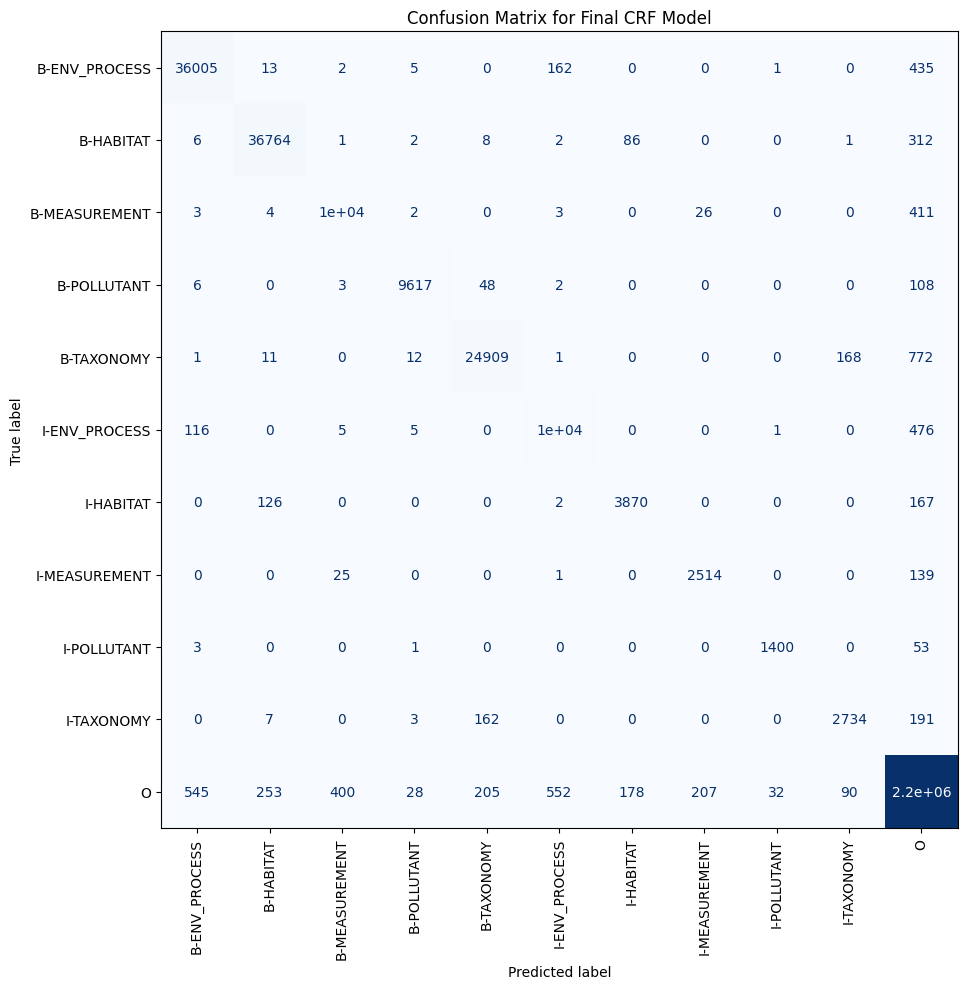

In [22]:
final_model = joblib.load(CRF_MODEL_PATH / "final_crf_model.joblib")

y_pred = final_model.predict(X_test)

# Flatten the true and predicted labels
y_test_flat = [label for seq in y_test for label in seq]
y_pred_flat = [label for seq in y_pred for label in seq]

# Compute confusion matrix
labels = sorted(set(y_test_flat) | set(y_pred_flat))
cm = confusion_matrix(y_test_flat, y_pred_flat, labels=labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix for Final CRF Model")
plt.tight_layout()
plt.show()

The confusion matrix shows that the final CRF model performs consistently well across all entity types, with most predictions falling along the diagonal. This indicates that the model is correctly identifying the majority of tokens for each class.

Frequent labels such as `B-ENV_PROCESS`, `B-HABITAT`, and `B-TAXONOMY` have strong precision and recall, with very few misclassifications. For instance, `B-HABITAT` achieves near-perfect classification with over 36,700 correct predictions and minimal confusion across other labels.

Rare or structurally ambiguous classes such as `I-TAXONOMY` and `I-MEASUREMENT` also perform well, though there are signs of confusion. `I-TAXONOMY` is occasionally mislabelled as `B-TAXONOMY` or O, while `I-MEASUREMENT` is misclassified 25 times as `B-MEASUREMENT`. This reflects the challenge of separating inner and beginning tags in long spans.

The non-entity label O is highly dominant, with over 2.2 million correct predictions. However, there are small numbers of false positives, where entity tokens are predicted as O. These mostly affect tail classes like `B-ENV_PROCESS` and `I-TAXONOMY`, suggesting that some entity boundaries may still be missed in difficult contexts.

Overall, the model is stable and consistent across entity types. While minor confusion exists between inner and beginning tags, especially for long or overlapping spans, the final model retains strong performance without excessive overfitting. This confirms its suitability as a reliable baseline for downstream evaluation.

#### Per-label F1 score
This section visualises the final CRF model’s performance across all entity types using a bar chart of per-label F1 scores. While the macro-average F1 offers a summary view, a breakdown by label helps identify which classes are handled well and which still need improvement.

This is especially important in a weakly labelled dataset like this one, where class imbalance and contextual ambiguity can impact certain entity types more than others. Visualising these differences helps support the confusion matrix findings and sets a clear baseline for the next model family.


/tmp/ipykernel_421621/3422684552.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="Blues_d")


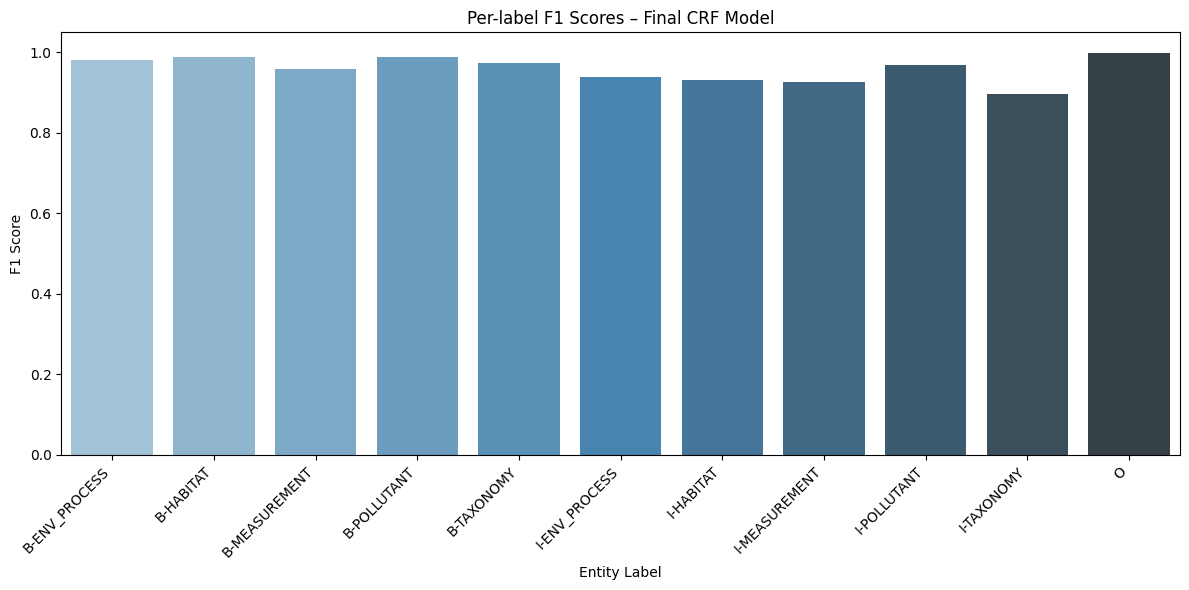

In [27]:
# Get per-label F1 scores
report = classification_report(y_test_flat, y_pred_flat, output_dict=True, zero_division=0)
f1_scores = {label: report[label]["f1-score"] for label in report if label not in ["accuracy", "macro avg", "weighted avg"]}

# Plot F1 scores
plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="Blues_d")
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.xlabel("Entity Label")
plt.ylim(0.0, 1.05)
plt.title("Per-label F1 Scores – Final CRF Model")
plt.tight_layout()
plt.show()

The bar chart confirms that the final CRF model performs consistently well across all entity types. Most entity labels achieve F1 scores above 0.90, indicating balanced precision and recall.

`B-ENV_PROCESS`, `B-HABITAT`, `B-POLLUTANT`, and `B-MEASUREMENT` all score above 0.96, suggesting strong recognition of beginning tokens for common entities. `B-TAXONOMY` also performs well despite its higher variability, reflecting the model’s capacity to generalise across biological terms.

Performance slightly drops for inner tokens, especially `I-TAXONOMY` and `I-MEASUREMENT`, where F1 dips below 0.90. This may be due to boundary ambiguity or inconsistent multi-token expressions. However, even these lower scores are relatively strong for a classical model trained without deep contextual embeddings.

The high F1 score for the O label is expected given its dominance in the dataset, but the model does not appear to sacrifice minority entity detection to maintain this.

Overall, the per-label scores reinforce earlier findings: the model captures surface-level patterns well, with minor challenges in complex or nested spans. This justifies transitioning to a contextual model in the next stage to improve performance on subtle or difficult cases.

#### Top misclassified labels
To better understand where the final CRF model struggles, this section identifies the most common misclassifications by comparing true and predicted labels. This helps highlight which entity types are most often confused and whether systematic errors occur across particular label pairs. Insights from this analysis can guide future improvements in feature design or support the case for moving to a more expressive model architecture.

In [29]:
misclassified = [(true, pred) for true, pred in zip(y_test_flat, y_pred_flat) if true != pred]

# Count the most common misclassifications
misclassified_counts = Counter(misclassified)
top_misclassified = misclassified_counts.most_common(10)

# Print results
print("Top 10 misclassified label pairs (true → predicted):\n")
for (true_label, pred_label), count in top_misclassified:
    print(f"{true_label} → {pred_label}: {count} times")


Top 10 misclassified label pairs (true → predicted):

B-TAXONOMY → O: 772 times
O → I-ENV_PROCESS: 552 times
O → B-ENV_PROCESS: 545 times
I-ENV_PROCESS → O: 476 times
B-ENV_PROCESS → O: 435 times
B-MEASUREMENT → O: 411 times
O → B-MEASUREMENT: 400 times
B-HABITAT → O: 312 times
O → B-HABITAT: 253 times
O → I-MEASUREMENT: 207 times


The most common error involves `B-TAXONOMY` being misclassified as `O` (772 instances), indicating the model often fails to detect the beginning of taxonomy entities. Several other errors also involve confusion between entity spans and the `O` tag, such as `B-ENV_PROCESS → O` (435 times) or `B-MEASUREMENT → O` (411 times), suggesting that the model struggles to confidently distinguish short or context-dependent entities from background tokens.

There are also notable cases of false positives from the `O` class into entity labels. For example, `O → I-ENV_PROCESS` (552 times) and `O → B-ENV_PROCESS` (545 times) suggest that the model sometimes wrongly extends entities into non-entity text, especially for multi-word expressions.

These errors reflect limitations in the CRF model’s reliance on local features. A CNN-based model in SpaCy may help by learning spatial patterns over a fixed window, and a transformer-based model could offer further improvements by leveraging broader sentence-level context and entity boundaries more accurately, especially for `TAXONOMY`, `ENV_PROCESS`, and nested `MEASUREMENT` spans.

#### Predicting Entities in a Raw Sentence
This section uses the trained CRF model to label a new sentence that is not part of the test set. It helps check if the model can spot useful environmental entities in unseen text.

In [31]:
sentence = (
    "During the long-term monitoring of freshwater ecosystems in the upper Thames basin, "
    "elevated concentrations of nitrates (above 50 mg/L) and phosphorus compounds were detected, "
    "particularly near agricultural runoff zones and peatland catchments. "
    "The decline of apple crab populations was observed concurrently with increased sedimentation, "
    "urban expansion, and rising temperatures due to climate change. "
    "In 2021, the average air temperature in deciduous woodland habitats exceeded 18 ° C "
    "contributing to a shift in breeding cycles among amphibians like rana temporaria."
)

tokens = sentence.split()

# Extract features and predict
features = sentence_to_features([(t, "O") for t in tokens])
predicted = final_model.predict([features])[0]

# Show token-level output
for token, label in zip(tokens, predicted):
    print(f"{token:<18} {label}")


During             O
the                O
long-term          O
monitoring         O
of                 O
freshwater         O
ecosystems         B-HABITAT
in                 O
the                O
upper              O
Thames             O
basin,             O
elevated           O
concentrations     O
of                 O
nitrates           B-POLLUTANT
(above             O
50                 O
mg/L)              O
and                O
phosphorus         B-POLLUTANT
compounds          O
were               O
detected,          O
particularly       O
near               O
agricultural       O
runoff             O
zones              O
and                O
peatland           O
catchments.        O
The                O
decline            O
of                 O
apple              B-TAXONOMY
crab               I-TAXONOMY
populations        O
was                O
observed           O
concurrently       O
with               O
increased          O
sedimentation,     O
urban              O
expansion

The model correctly identified several key entities, including:

- `ecosystems` as `B-HABITAT`
- `nitrates` and phosphorus as `B-POLLUTANT`
- `apple crab` and amphibians as `TAXONOMY`
- `climate change` as `B-ENV_PROCESS`
- `temperature` values like `temperature` and `°C` as parts of `MEASUREMENT`
- `habitats` and `woodland habitats` as `HABITAT`

Some entities were missed or partially labelled, such as:

- `rana temporaria` which was not detected as `TAXONOMY`
- `peatland catchments`, which was not labelled as `HABITAT`
- numeric values and units like `50 mg/L` were not fully joined as a `MEASUREMENT`

Despite these gaps, the model generalised reasonably well to a realistic passage containing a wide mix of vocabulary, phrasing, and domain-specific structure. The strong entity boundaries and label assignments show the model has learned useful patterns. However, incomplete or inconsistent annotations (e.g. temperature units split across tokens) suggest further improvements could come from better handling of multi-word expressions, rare terms, and complex measurement formats.

## 4. Final Summary

### 4.1 Summary of CRF Modelling
This notebook trained and evaluated a series of Conditional Random Field (CRF) models to serve as a classical baseline for domain-specific named entity recognition. Six different models were tested by adjusting the L1 and L2 regularisation strengths and optimisation steps. The best-performing model balanced regularisation `c1 = 0.05`, `c2 = 0.3` and generalisation, achieving a macro-average F1 score of 0.96 on the test set.

The model was able to correctly identify and label common entities such as `B-HABITAT`, `B-ENV_PROCESS`, and `O` with high accuracy. However, several challenges were observed:

- Lower recall for difficult or rare entity spans such as `I-TAXONOMY`.
- Frequent misclassifications between entity tokens and the `O` class.
- Dependence on hand-engineered features and lack of contextual understanding.

These limitations highlight the CRF’s reliance on surface-level patterns and limited memory across token sequences.

#### 4.2 Next Steps
The next stage will involve training a neural network-based model using SpaCy’s convolutional neural network (CNN) pipeline. A CNN processes local context using sliding filters over token embeddings, allowing it to capture character-level and n-gram patterns automatically.

Unlike CRFs, CNN models do not require manual feature engineering and can better learn positional and morphological cues. This can help reduce false negatives (e.g. `B-TAXONOMY → O`) and improve detection of embedded or compound entities, particularly those with complex surface forms. The CNN model will also be tested for its ability to generalise better across sentence structures and entity variations found in environmental science texts.